In [2]:
import gym
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

env = gym.make('Taxi-v3').env
# env = gym.make('Taxi-v3', render_mode='human').env # if we want to render
# We are using the .env on the end of make to avoid training stopping at 200 iterations, which is the default for the new version of Gym (?)

action = env.action_space.sample()  # take a random action

env.reset()
env.step(action)


# 1-south
# 2-north
# 3-east
# 4-west
# 5-pickup
# 6-dropoff

(283,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [2]:
for i in range(3):
    action = env.action_space.sample()  # take a random action
    observation, reward, done, info, action_mask = env.step(action)
    # observation: Observations of the environment
    # reward: If your action was beneficial or not
    # done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
    # info: Additional info such as performance and latency for debugging purposes
    print(f"Step {i+1}:")
    print(env.step(action))
    env.render() # Renders one frame of the environment (helpful in visualizing the environment)

Step 1:
(291, -10, False, False, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})
Step 2:
(291, -1, False, False, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})
Step 3:
(491, -1, False, False, {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)})


In [3]:
'''
"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."
'''

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

'''
The 6 actions typically represent the taxi’s possible movements (south, north, east, west, pickup, dropoff)

and the 500 states represent the different combinations of taxi locations, passenger locations, and destination locations:

Taxi Locations: The taxi can be in one of 25 locations on a 5x5 grid, which gives us 25 possible taxi locations.
Passenger Locations: The passenger can be at one of 5 locations (4 destinations + 1 in the taxi), which gives us 5 possible passenger locations.
Destination Locations: There are 4 possible destinations.
So, the total number of states is the product of these three quantities: 25 (taxi locations) * 5 (passenger locations) * 4 (destination locations) = 500.

This means that there are 500 different situations (states) that our agent could possibly encounter in this environment
'''

Action Space Discrete(6)
State Space Discrete(500)


'\nThe 6 actions typically represent the taxi’s possible movements (south, north, east, west, pickup, dropoff)\n\nand the 500 states represent the different combinations of taxi locations, passenger locations, and destination locations:\n\nTaxi Locations: The taxi can be in one of 25 locations on a 5x5 grid, which gives us 25 possible taxi locations.\nPassenger Locations: The passenger can be at one of 5 locations (4 destinations + 1 in the taxi), which gives us 5 possible passenger locations.\nDestination Locations: There are 4 possible destinations.\nSo, the total number of states is the product of these three quantities: 25 (taxi locations) * 5 (passenger locations) * 4 (destination locations) = 500.\n\nThis means that there are 500 different situations (states) that our agent could possibly encounter in this environment\n'

In [4]:
 # if we have the taxi at row 3, column 1, our passenger is at location 2, and our destination is location 0:

# env.reset()
# setting the state manually not allowed in certain environments

state = env.encode(4, 4, 4, 3) # (taxi row [0-4], taxi column[0-4], passenger index[0-4] (4 if passenger on taxi) , destination index[0-3])
print("State:", state)

env.s = state

env.render()

State: 499


In [5]:
'''
Reward Table
'''

# The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
# In this env, probability is always 1.0.
# The nextstate is the state we would be in if we take the action at this index of the dict
# All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
# done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

print(len(env.P))
env.P[499]

500


{0: [(1.0, 499, -1, False)],
 1: [(1.0, 399, -1, False)],
 2: [(1.0, 499, -1, False)],
 3: [(1.0, 479, -1, False)],
 4: [(1.0, 499, -10, False)],
 5: [(1.0, 499, -10, False)]}

In [ ]:
# Solving the environment without Reinforcement Learning

# env.s = 499  # set environment to illustration's state

total_epochs, total_penalties = 0, 0 # epochs==step, penalties==wrong pick up, drop off
episodes = 10

for i in range(1, episodes):

    epochs = 0 # a epoch is just one step
    penalties, reward = 0, 0

    # frames = [] # for animation

    done = False
    state = env.reset()[0]

    while not done:
        action = env.action_space.sample()
        # time.sleep(0.0001)
        state, reward, done, info, _ = env.step(action)

        # env.render()

        if reward == -10:
            penalties += 1


        # # Put each rendered frame into dict for animation
        # frames.append({
        #     'frame': env.render(), #(mode='ansi'),
        #     'state': state,
        #     'action': action,
        #     'reward': reward
        #     }
        # )

        epochs += 1
        clear_output(wait=True)
        print('Episode', i, 'steps', epochs, 'penalties', penalties, 'done', done, 'state', state, 'action', action)
    
    
    total_penalties += penalties
    total_epochs += epochs
    
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / (episodes-1)}")
print(f"Average penalties per episode: {total_penalties / (episodes-1)}")


Episode 9 steps 4319 penalties 1350 done False state 251 action 1


In [10]:
# skip if q_table already trained and saved

'''
%%time

# Implementing Q-learning

# First, we'll initialize the Q-table to a 500*6 matrix of zeros:

q_table = np.zeros([env.observation_space.n, env.action_space.n])

"""Training the agent"""

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.3

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 3000):
    state = env.reset()[0]

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, _ = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
        clear_output(wait=True)
        print('Episode', i)
        print('steps', epochs)
        print('state:', state)
        print('next_state:', next_state)
        print('action:', action)
        print('next_max:', next_max)
        print('reward:', reward)
        print('penalties:', penalties)
        print('epsilon:', epsilon)
        
    all_epochs.append(epochs)
    all_penalties.append(penalties)
    epsilon -= 0.0001

print("Training finished.\n")
'''

'\n%%time\n\n# Implementing Q-learning\n\n# First, we\'ll initialize the Q-table to a 500*6 matrix of zeros:\n\nq_table = np.zeros([env.observation_space.n, env.action_space.n])\n\n"""Training the agent"""\n\n# Hyperparameters\nalpha = 0.1\ngamma = 0.6\nepsilon = 0.3\n\n# For plotting metrics\nall_epochs = []\nall_penalties = []\n\nfor i in range(1, 3000):\n    state = env.reset()[0]\n\n    epochs, penalties, reward, = 0, 0, 0\n    done = False\n    \n    while not done:\n        if random.uniform(0, 1) < epsilon:\n            action = env.action_space.sample() # Explore action space\n        else:\n            action = np.argmax(q_table[state]) # Exploit learned values\n\n        next_state, reward, done, info, _ = env.step(action) \n        \n        old_value = q_table[state, action]\n        next_max = np.max(q_table[next_state])\n        \n        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)\n        q_table[state, action] = new_value\n\n        if rew

In [8]:
# # Save the array to a file
# np.save('q_table.npy', q_table)

In [4]:
# Load the array from the file
q_table = np.load('q_table.npy')
print(q_table.shape)
np.round(q_table, 5)

(500, 6)


array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [-2.35484, -2.32768, -2.34644, -2.31583, -2.27325, -9.75691],
       [-1.8197 , -1.54662, -1.76067, -1.58554, -0.7504 , -5.44264],
       ...,
       [-1.14125, -0.90996, -1.14478, -1.15618, -5.40945, -3.55101],
       [-2.11404, -2.10632, -2.11318, -2.10696, -7.11642, -7.79209],
       [-0.196  ,  0.21011, -0.18097,  9.85536, -1.43697, -1.9114 ]])

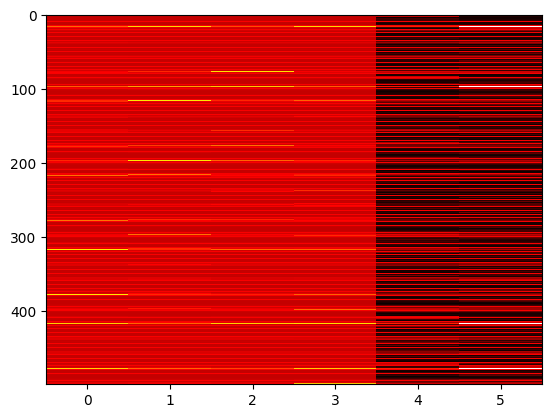

In [6]:
# Create a heatmap
plt.imshow(q_table, cmap='hot', interpolation='nearest', aspect='auto')

# Show the plot
plt.show()

In [7]:
rewards = []
for state, actions in env.P.items():
    for action, details in actions.items():
        rewards.append(details[0][2])

orig_rewards = np.array(rewards).reshape(q_table.shape[0], q_table.shape[1])
orig_rewards

array([[ -1,  -1,  -1,  -1,  -1, -10],
       [ -1,  -1,  -1,  -1,  -1, -10],
       [ -1,  -1,  -1,  -1,  -1, -10],
       ...,
       [ -1,  -1,  -1,  -1, -10, -10],
       [ -1,  -1,  -1,  -1, -10, -10],
       [ -1,  -1,  -1,  -1, -10, -10]])

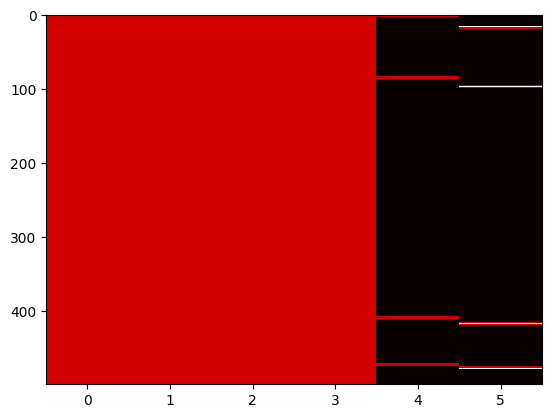

In [8]:
# Create a heatmap
plt.imshow(orig_rewards, cmap='hot', interpolation='nearest', aspect='auto')

# Show the plot
plt.show()

In [18]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0 # epochs==step, penalties==wrong pick up, drop off
episodes = 10
# If your Q-table has been correctly learned during training, then in theory, you should be able to use a purely greedy policy (always choosing the action with the highest Q-value) and still achieve optimal performance. In this case, insteas, we use a epsilon also here
epsilon = 0.3  # probability of choosing a random action

for i in range(1, episodes):
    
    epochs, penalties, reward = 0, 0, 0
    done = False
 
    state = env.reset()[0]

    
    while not done:
        
        # env.render()
        
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # take random action
        else:
            action = np.argmax(q_table[state])  # take action with max Q-value
        
        state, reward, done, info, _ = env.step(action)


        if reward == -10:
            penalties += 1

        epochs += 1
        
        clear_output(wait=True)
        print('Episode', i, 'steps', epochs, 'penalties', penalties, 'done', done, 'state', state, 'action', action)

    total_penalties += penalties
    total_epochs += epochs
    
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / (episodes-1)}")
print(f"Average penalties per episode: {total_penalties / (episodes-1)}")



Episode 9 steps 17 penalties 2 done True state 475 action 5
Results after 10 episodes:
Average timesteps per episode: 43.44444444444444
Average penalties per episode: 4.555555555555555


In [162]:
env.step(action)



(284,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})